# 0. Setting Up The Env

## 0.1 Packages

In [191]:
from pathlib import Path

In [192]:
import pandas as pd 
import numpy as np


from scipy.stats import chi2_contingency

In [193]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [195]:
from mpl_toolkits.mplot3d import Axes3D

## 0.2 Utilities

In [196]:
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic 
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, exp = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))), chi2, p

def association_with_target(df, x_list, y):
    """
    Test association between target categorical variable y and categorical features in x_list.
    """
    results = []
    for col in x_list:
        v, chi2, p = cramers_v(df[col], df[y])
        results.append({
            "Feature": col,
            "Target": y,
            "Cramer's V": round(v, 3),
            "Chi2 Statistic": round(chi2, 3),
            "p-value": round(p, 5),
            "Significance": "Significant" if p < 0.05 else "Not Significant"
        })
    return pd.DataFrame(results)

In [197]:
def get_dummies_drop_least(df, cols):
    df_new = df.copy()
    for col in cols:
        # Find the category with the fewest values
        least_common = df[col].value_counts().idxmin()
        
        # One-hot encode this column
        dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
        
        # Drop the least frequent category
        dummies = dummies.drop(f"{col}_{least_common}", axis=1)
        
        # Join with original dataframe (drop original col)
        df_new = df_new.drop(columns=[col]).join(dummies)
    
    return df_new

## 0.3 Constants

In [198]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [221]:
raw_file_path = f"{project_root}/data/raw/bank.csv"
processed_file_path = f"{project_root}/data/processed/preprocessed_bank.csv"
raw_file_path, processed_file_path

('d:\\01 Work\\06-Segmentations/data/raw/bank.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/preprocessed_bank.csv')

# 1. The Data

In [ ]:
data_df  = pd.read_csv(raw_file_path, sep=";")
print(f"The data has {data_df.shape[0]} rows and {data_df.shape[1]} columns")
print("Data Preview:")
data_df.head()

The data has 4521 rows and 17 columns
Data Preview:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# 2. Data Check

In [201]:
print(data_df.isnull().sum())




age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [202]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


## 2.1 Target Var

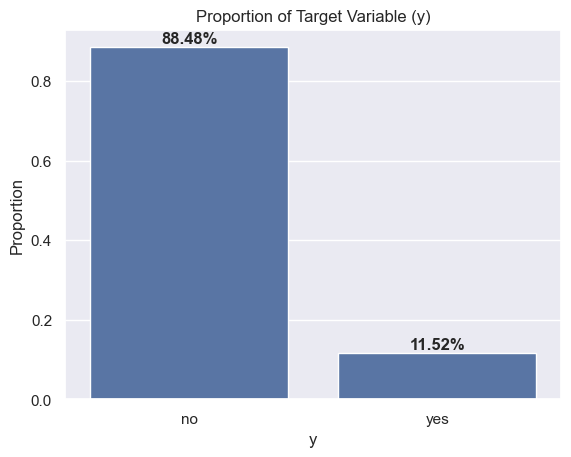

In [203]:
ax = sns.barplot(
    x=data_df['y'].value_counts(normalize=True).index,
    y=data_df['y'].value_counts(normalize=True).values,
)

# Add percentage labels
for i, v in enumerate(data_df['y'].value_counts(normalize=True).values):
    ax.text(i, v + 0.01, f"{v:.2%}", ha="center", fontweight="bold")

ax.set_title("Proportion of Target Variable (y)")
ax.set_xlabel("y")
ax.set_ylabel("Proportion")
plt.show()

## 2.2 Numeric Columns

In [204]:
data_df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,4521.0,41.170095,10.576211,19.0,33.0,39.0,49.0,87.0
balance,4521.0,1422.657819,3009.638142,-3313.0,69.0,444.0,1480.0,71188.0
day,4521.0,15.915284,8.247667,1.0,9.0,16.0,21.0,31.0
duration,4521.0,263.961292,259.856633,4.0,104.0,185.0,329.0,3025.0
campaign,4521.0,2.793630,3.109807,1.0,1.0,2.0,3.0,50.0
pdays,4521.0,39.766645,100.121124,-1.0,-1.0,-1.0,-1.0,871.0
previous,4521.0,0.542579,1.693562,0.0,0.0,0.0,0.0,25.0


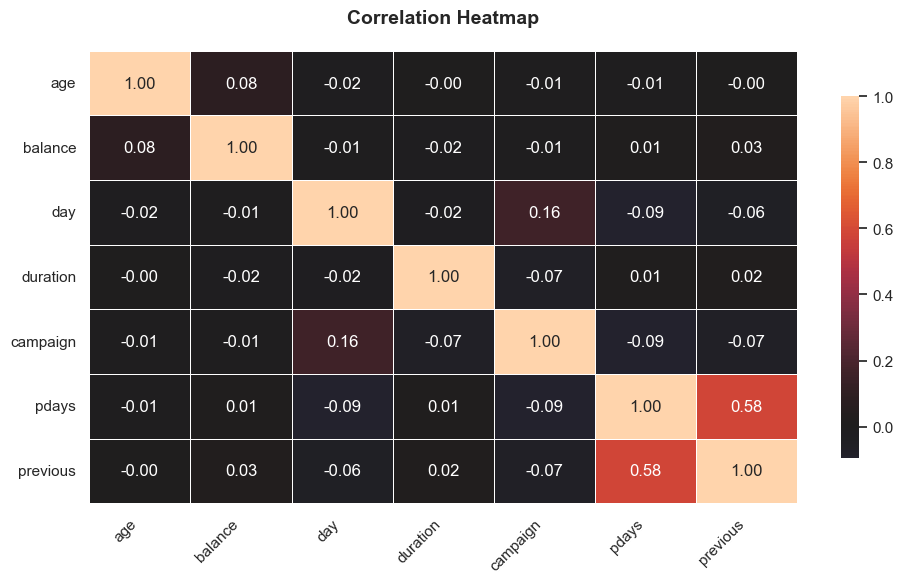

In [205]:
plt.figure(figsize=(10, 6))
corr = data_df.corr(numeric_only=True)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # add grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

No strong correlations between anything, other than **pdays**(*number of days that passed by after the client was last contacted from a previous campaign*) and **previous**(*number of contacts performed before this campaign and for this client*) which shows medium correlationship

## 2.3 Categorical Columns

In [206]:
data_df.describe(include=['O']).T

,count,unique,top,freq
job,4521,12,management,969
marital,4521,3,married,2797
education,4521,4,secondary,2306
default,4521,2,no,4445
housing,4521,2,yes,2559
loan,4521,2,no,3830
contact,4521,3,cellular,2896
month,4521,12,may,1398
poutcome,4521,4,unknown,3705
y,4521,2,no,4000


In [207]:
for col in data_df.select_dtypes(include="object"):
    print( data_df[col].value_counts(normalize=True))
    print("*"*100)

job
management       0.214333
blue-collar      0.209246
technician       0.169874
admin.           0.105729
services         0.092236
retired          0.050874
self-employed    0.040478
entrepreneur     0.037160
unemployed       0.028312
housemaid        0.024773
student          0.018580
unknown          0.008405
Name: proportion, dtype: float64
****************************************************************************************************
marital
married     0.618668
single      0.264543
divorced    0.116788
Name: proportion, dtype: float64
****************************************************************************************************
education
secondary    0.510064
tertiary     0.298607
primary      0.149967
unknown      0.041363
Name: proportion, dtype: float64
****************************************************************************************************
default
no     0.98319
yes    0.01681
Name: proportion, dtype: float64
******************************************

* **Month** Can be converted to periodic for numeric calculations
* *Binary Columns* can also be converted for easier calculations

# 3. Association Tests

In [208]:
object_cols = data_df.select_dtypes(include=["object"]).columns.tolist()
object_cols = object_cols[:-1]
print(len(object_cols))

9


In [209]:
insight_table = association_with_target(data_df, object_cols, "y")
print(insight_table)

     Feature Target  Cramer's V  Chi2 Statistic  p-value     Significance
0        job      y       0.113          68.988  0.00000      Significant
1    marital      y       0.061          19.030  0.00007      Significant
2  education      y       0.052          15.237  0.00163      Significant
3    default      y       0.000           0.000  1.00000  Not Significant
4    housing      y       0.103          48.885  0.00000      Significant
5       loan      y       0.068          21.872  0.00000      Significant
6    contact      y       0.138          87.870  0.00000      Significant
7      month      y       0.230         250.500  0.00000      Significant
8   poutcome      y       0.291         386.877  0.00000      Significant


# 4. Data Changes

## 4.1 Categorical To Numerical

In [210]:
new_data_df = data_df.copy(deep=True)


In [211]:
new_data_df['num_month'] = new_data_df['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12})
new_data_df['sin_month'] = np.sin(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df['cos_month'] = np.cos(new_data_df['num_month'] * (2 * np.pi / 12))
new_data_df.drop(columns=["month", "num_month"], inplace=True)

## 4.2 Categorical To Binary

In [212]:
temp = new_data_df.describe(include=['O']).T
temp = temp[temp["unique"] == 2].index.tolist()
temp

['default', 'housing', 'loan', 'y']

In [213]:
for col in temp:
    new_data_df[col] = new_data_df[col].map({"yes": 1, "no": 0})

new_data_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,pdays,previous,poutcome,y,sin_month,cos_month
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,79,1,-1,0,unknown,0,-8.660254e-01,0.500000
1,33,services,married,secondary,0,4789,1,1,cellular,11,220,1,339,4,failure,0,5.000000e-01,-0.866025
2,35,management,single,tertiary,0,1350,1,0,cellular,16,185,1,330,1,failure,0,8.660254e-01,-0.500000
3,30,management,married,tertiary,0,1476,1,1,unknown,3,199,4,-1,0,unknown,0,1.224647e-16,-1.000000
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,226,1,-1,0,unknown,0,5.000000e-01,-0.866025


## 4.3 Rest Categorical

In [214]:
temp = new_data_df.describe(include=['O']).T
temp = temp[temp["unique"] > 2].index.tolist()
temp

['job', 'marital', 'education', 'contact', 'poutcome']

In [215]:
df_encoded = get_dummies_drop_least(new_data_df, temp)
df_encoded.head() 

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,30,0,1787,0,0,19,79,1,-1,0,...,1,0,1,0,0,1,0,0,0,1
1,33,0,4789,1,1,11,220,1,339,4,...,1,0,0,1,0,1,0,1,0,0
2,35,0,1350,1,0,16,185,1,330,1,...,0,1,0,0,1,1,0,1,0,0
3,30,0,1476,1,1,3,199,4,-1,0,...,1,0,0,0,1,0,1,0,0,1
4,59,0,0,1,0,5,226,1,-1,0,...,1,0,0,1,0,0,1,0,0,1


# 5. Plot

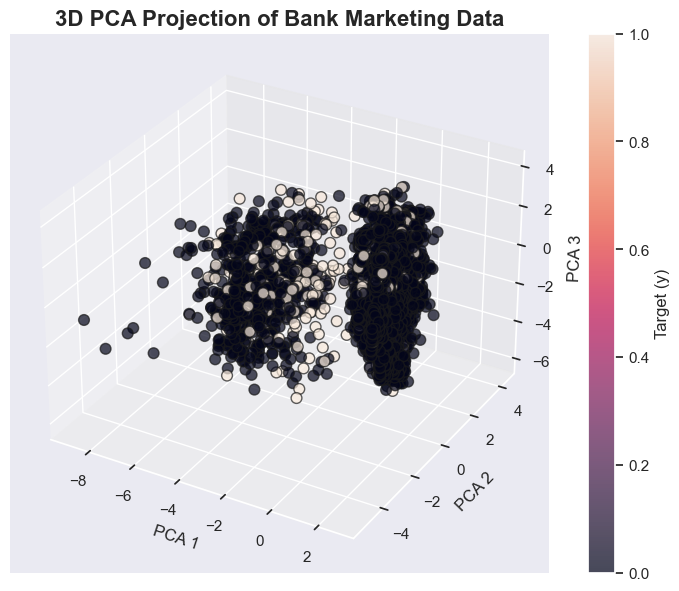

In [219]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], 
    c=y,  alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()

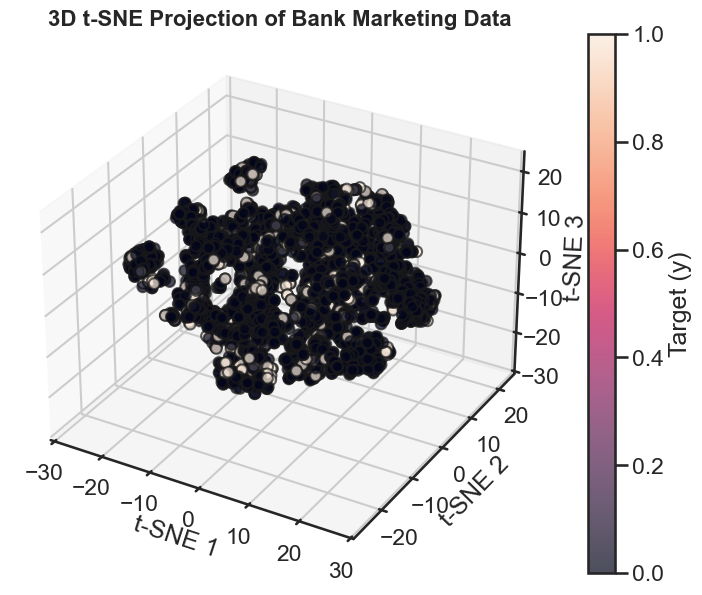

In [220]:
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_tsne_3d[:,0], X_tsne_3d[:,1], X_tsne_3d[:,2],
    c=y, alpha=0.7, s=60, edgecolor="k"
)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.set_title("3D t-SNE Projection of Bank Marketing Data", fontsize=16, weight="bold")
fig.colorbar(sc, ax=ax, label="Target (y)")
plt.show()


# 6. Save

In [222]:
df_encoded.to_csv(processed_file_path, index=False)

# END